/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


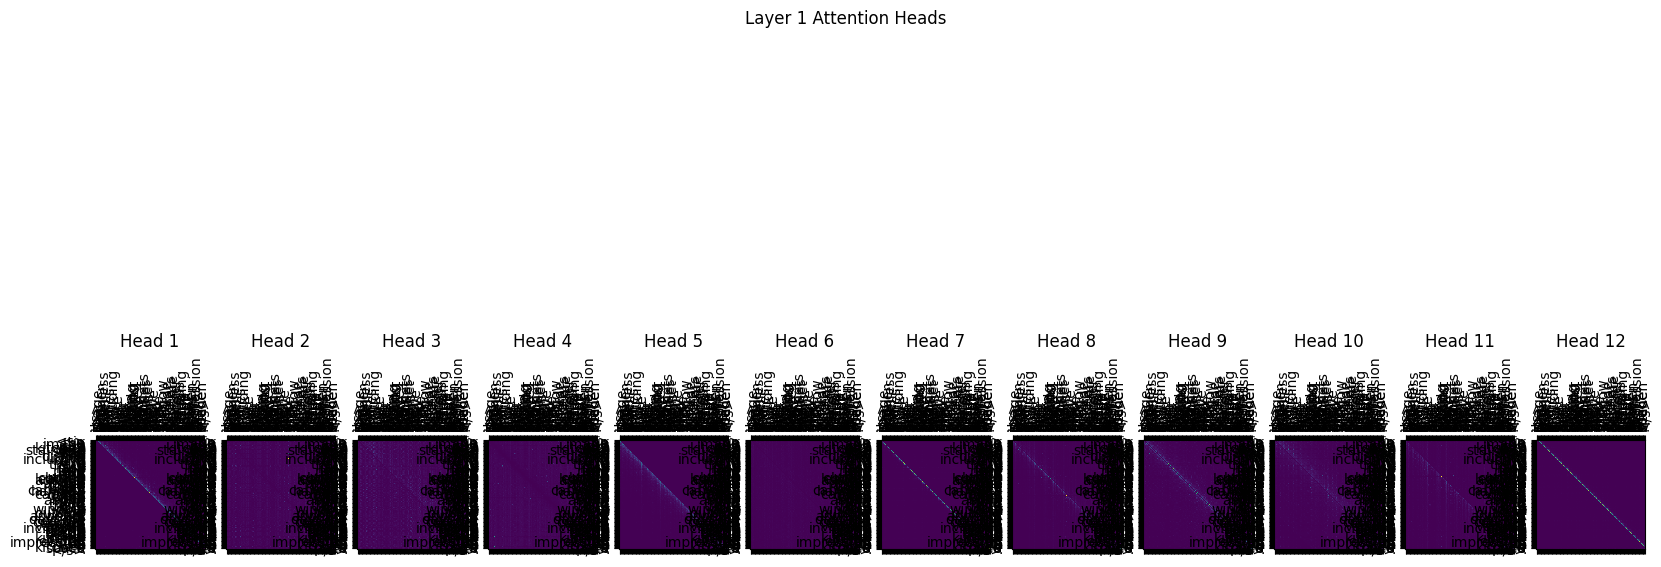

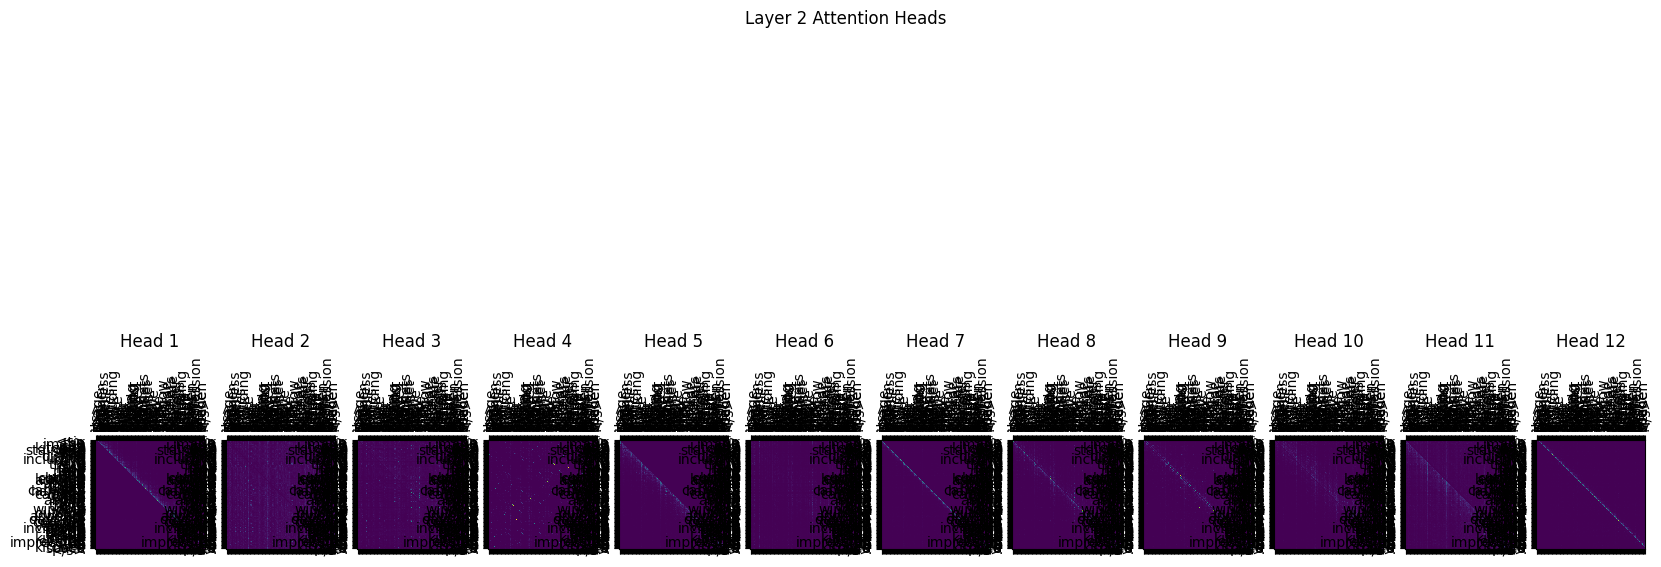

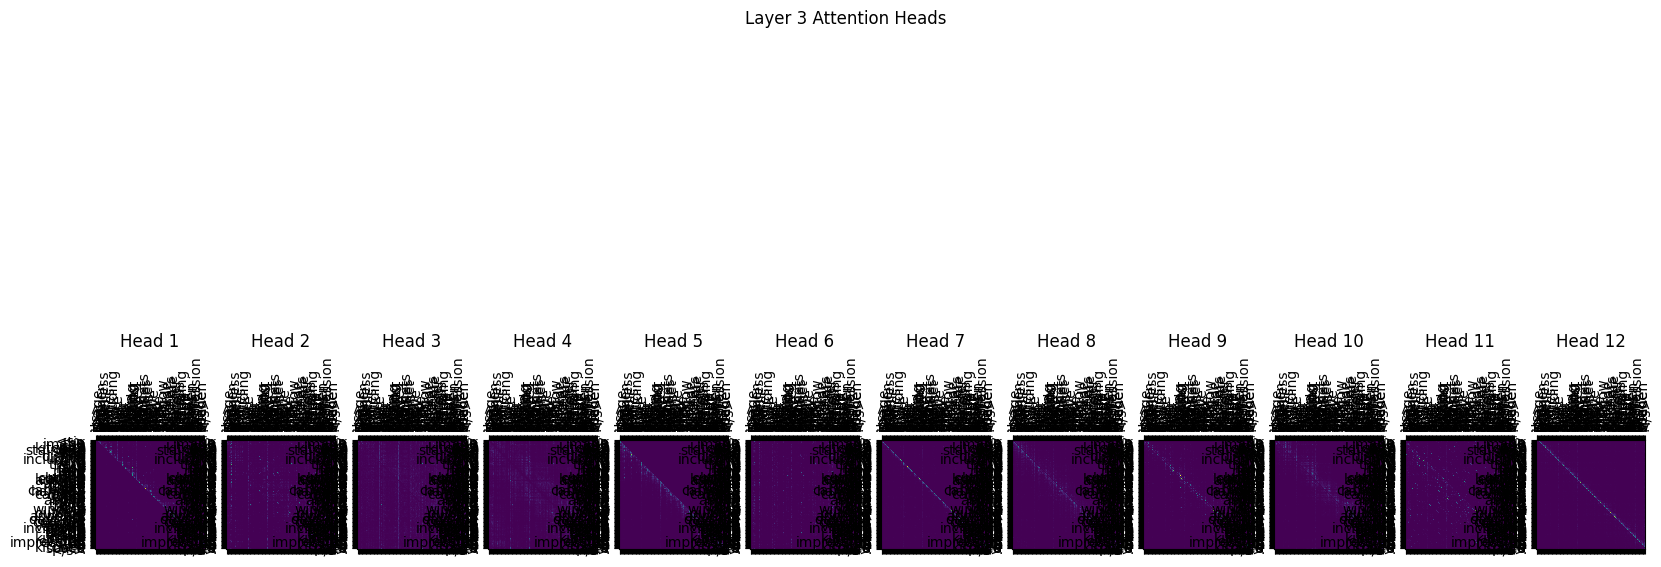

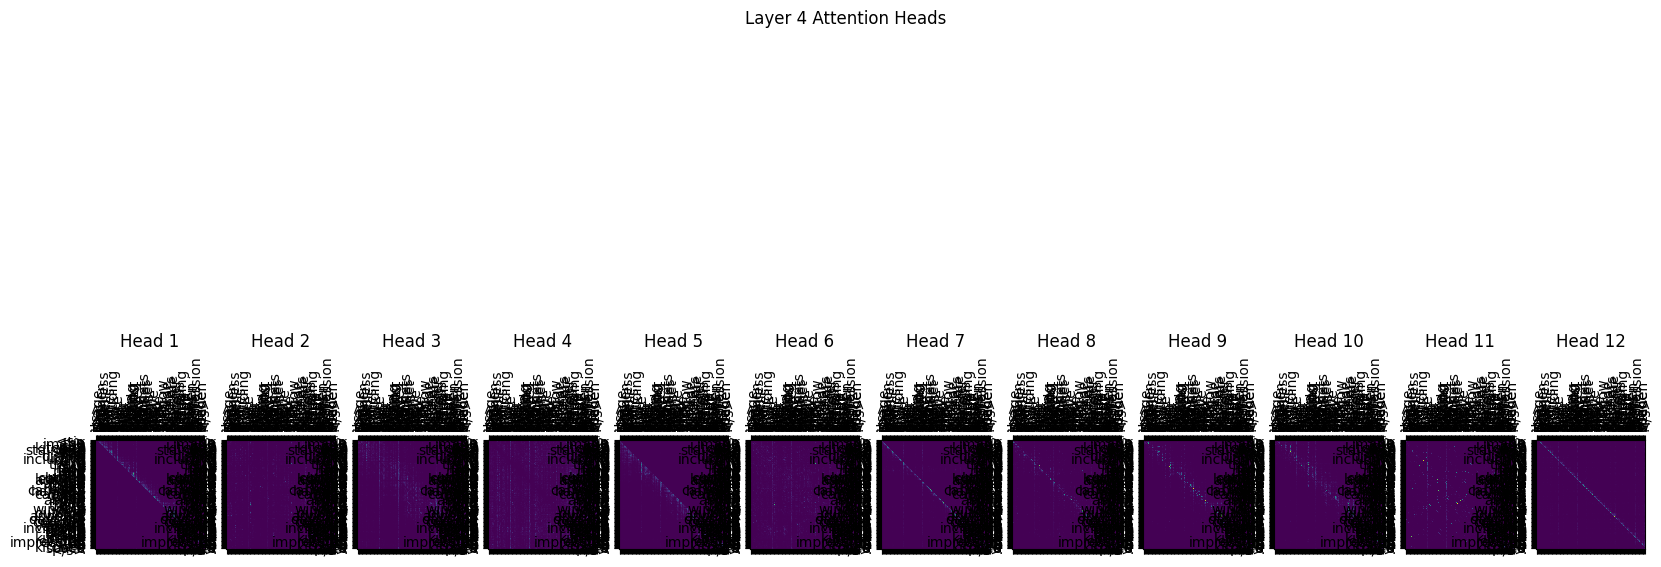

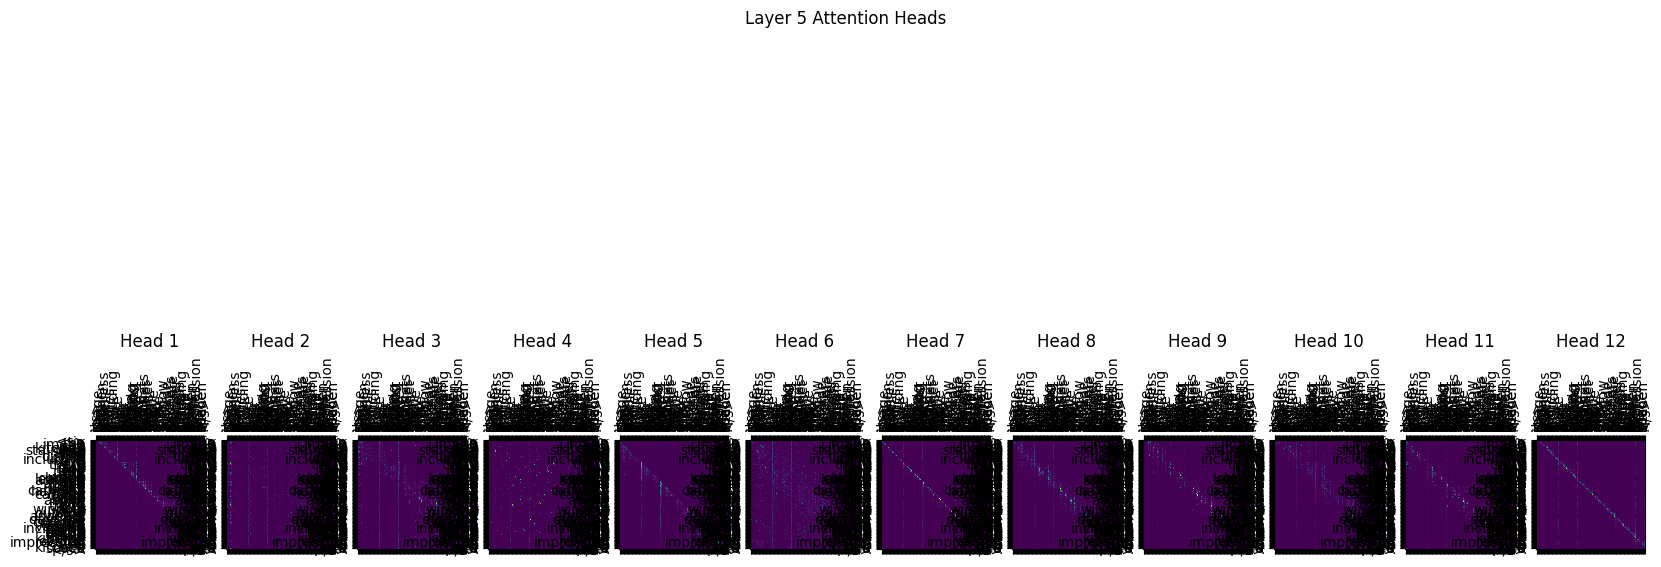

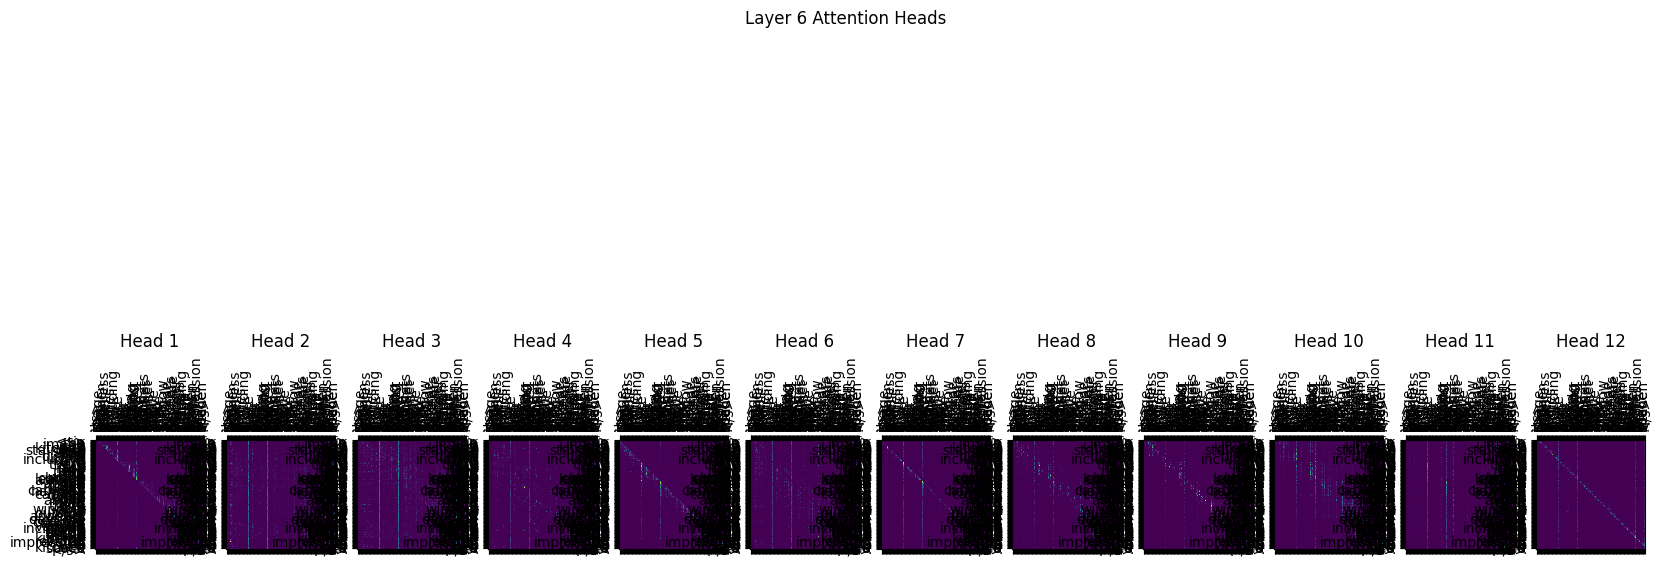

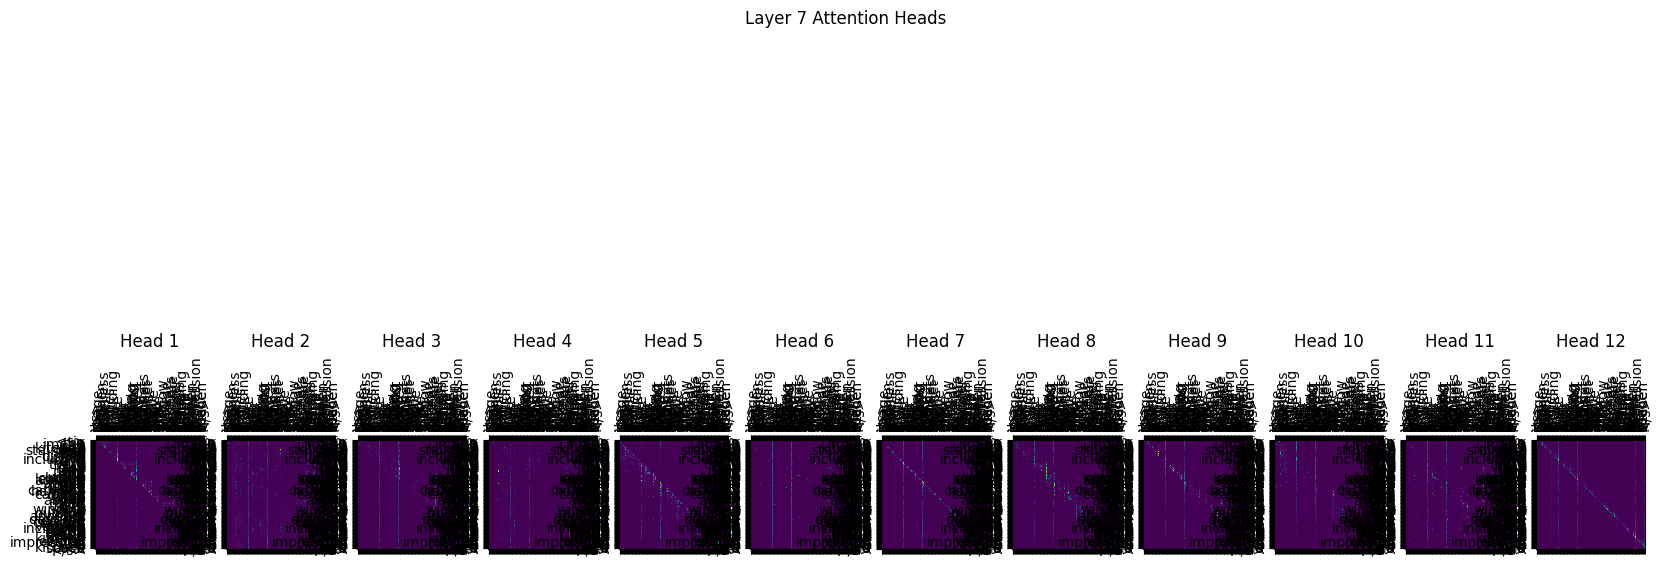

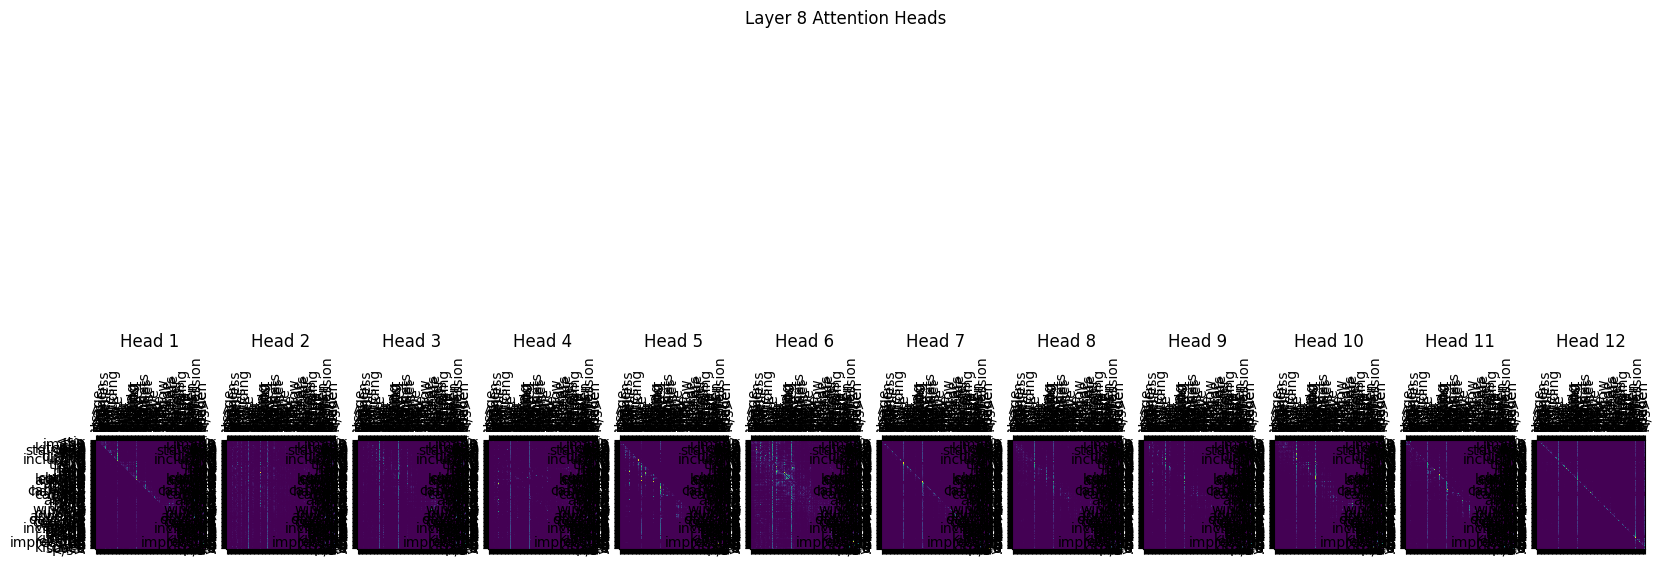

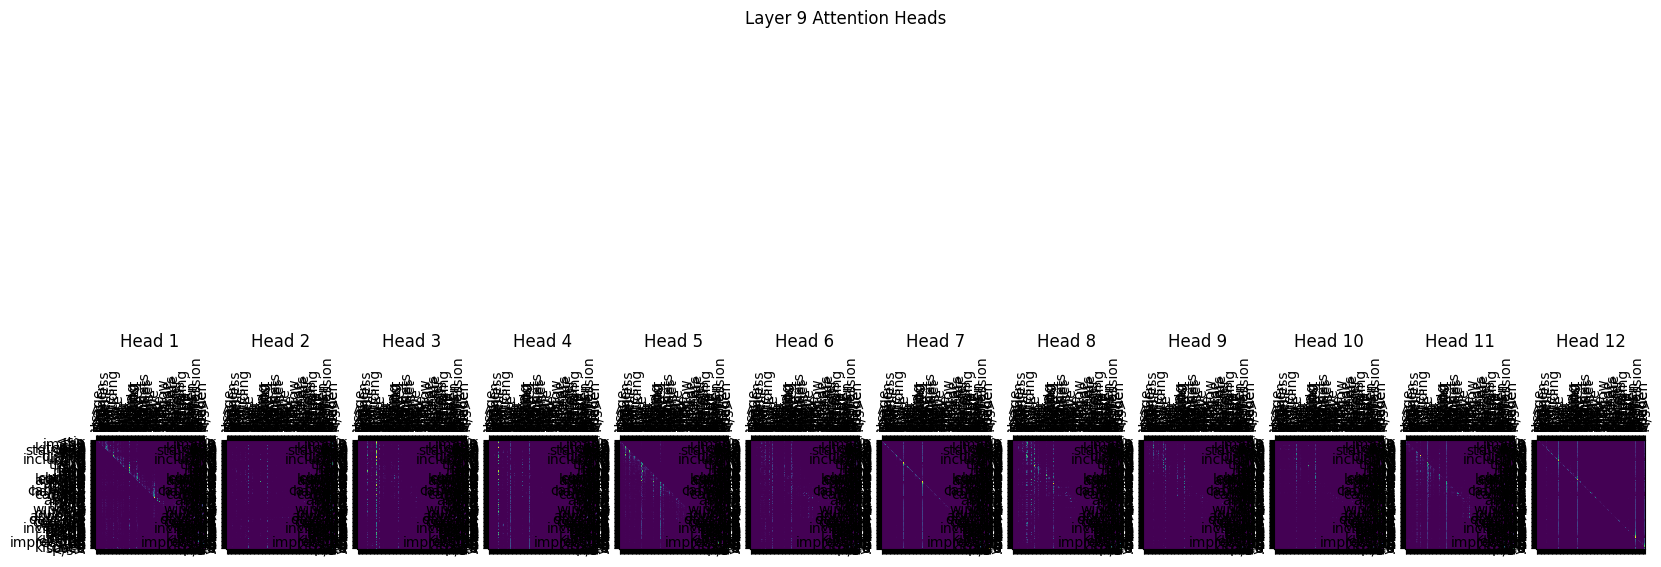

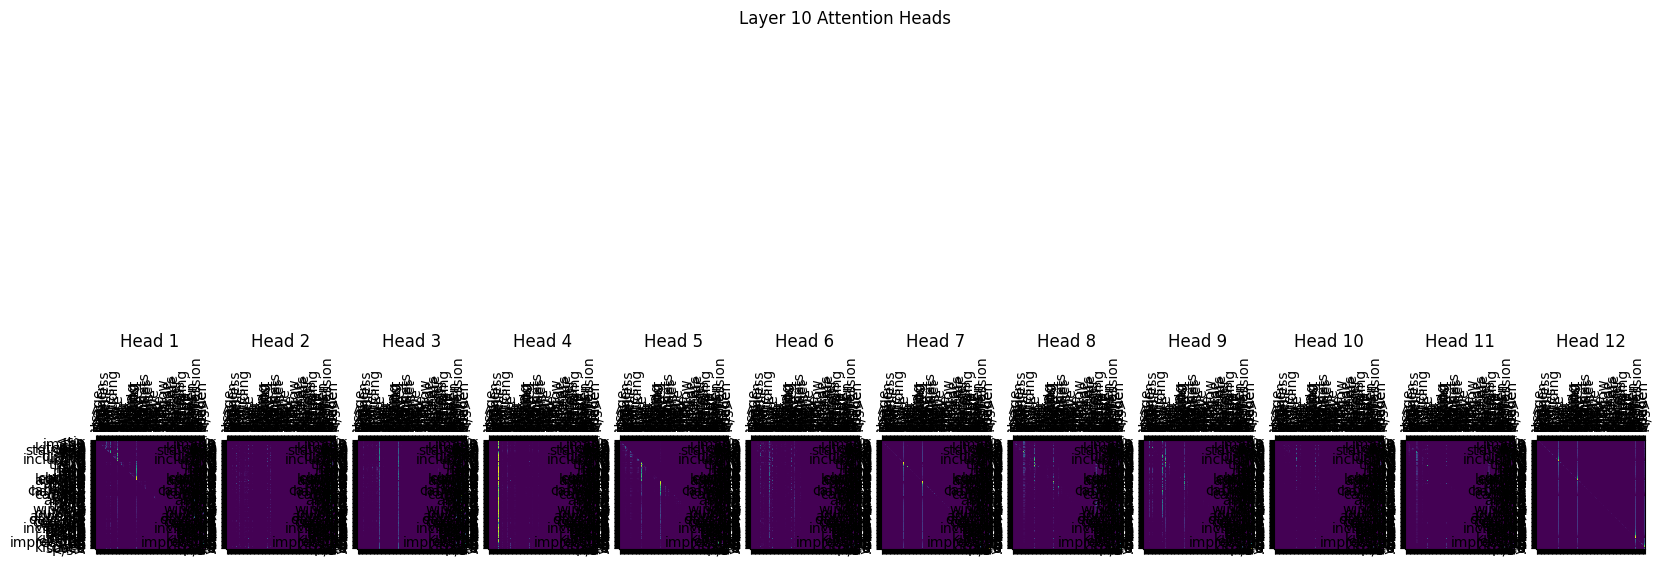

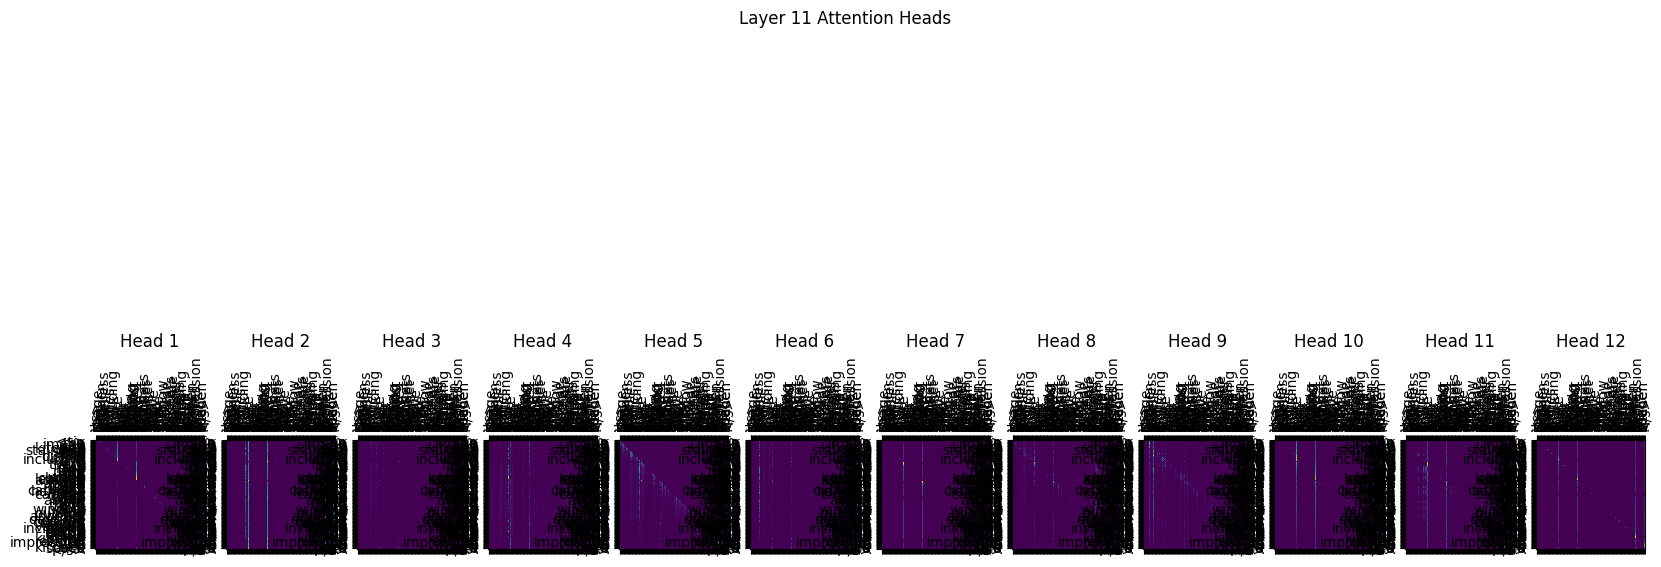

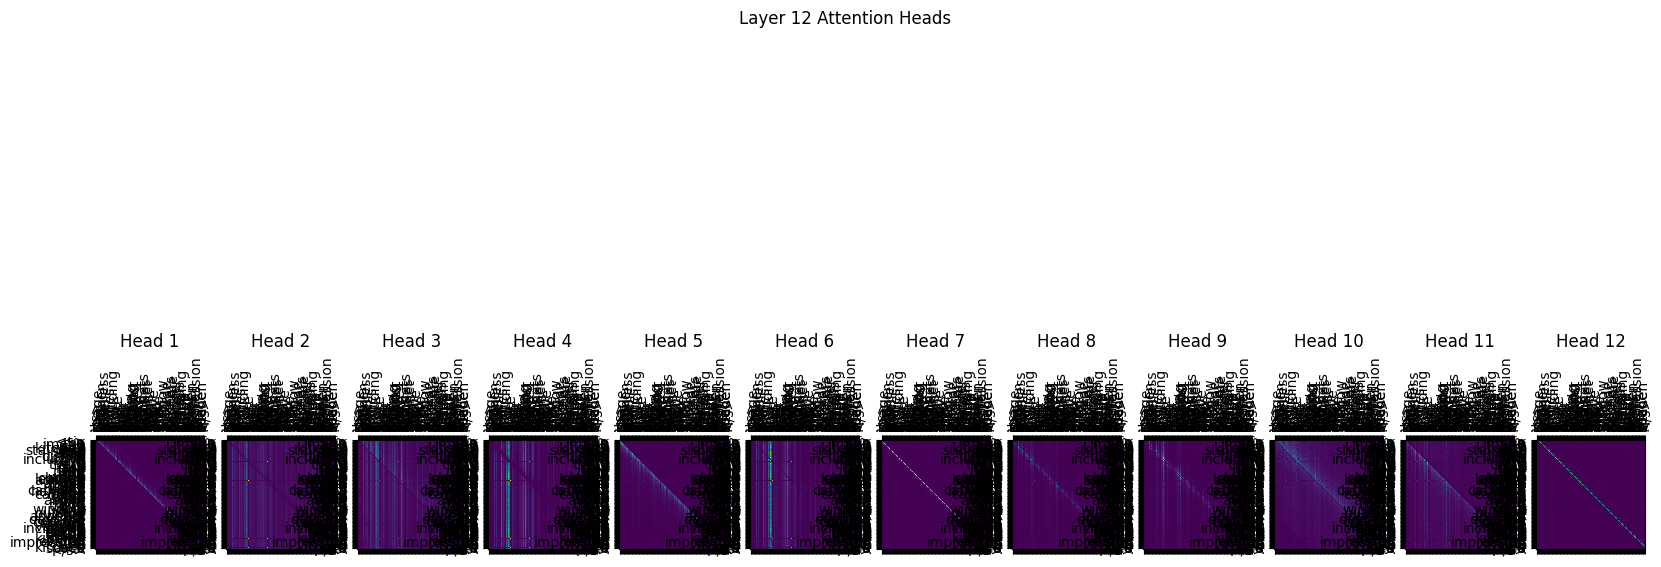

In [12]:
import torch
from sentence_transformers import SentenceTransformer
from transformers import MPNetTokenizer, MPNetModel
import matplotlib.pyplot as plt

# Function to visualize the attention weights for each layer
def plot_attention_heads_for_layer(layer_index, attention_heads, tokens):
    num_heads = attention_heads.size(0)
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))
    for i, ax in enumerate(axs):
        ax.matshow(attention_heads[i].cpu(), cmap='viridis')
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=90)
        ax.set_yticklabels(tokens)
        ax.set_title(f'Head {i+1}')
    plt.suptitle(f'Layer {layer_index+1} Attention Heads')
    plt.show()

# Load pre-trained MPNet tokenizer
tokenizer = MPNetTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize input text
text = "In the image, I see a kitchen with a stainless steel sink that has a few dishes in it, including a bowl and a cup. There's a dish rack on the right side of the sink, and a white cutting board leaning against the wall. Above the sink, there are two black cabinets with handles, and the cabinet doors are open. The wall above the sink is tiled, and there's a window with a view of the outside, where it appears to be daytime. On the countertop, there are various items including a bottle, a green spray bottle, and a few other kitchen items. The overall impression is of a well-used kitchen space."
tokens = tokenizer.tokenize(text)
input_ids = tokenizer.encode(text, return_tensors='pt').cuda()

# Load your fine-tuned SentenceTransformer model
model_path = '/data/gunsbrother/prjs/ltvu/everything/sbert_finetune/outputs/batch/2024-06-07/17-03-43/lit/103204/checkpoints/step=3834-nlq_R5@0.3=0.0000.ckpt'
model = SentenceTransformer('all-mpnet-base-v2').cuda().eval()
model.load_state_dict(
    {k.replace('model.model.', '0.auto_model.'): v for k, v in torch.load(model_path)['state_dict'].items()},
    strict=False
)

# Extract the underlying MPNet model
mpnet_model = model[0].auto_model

# Forward pass, obtain hidden states and attention weights
with torch.no_grad():
    outputs = mpnet_model(input_ids, output_attentions=True)
    attentions = outputs.attentions  # list of attention maps for each layer

# Convert tokens IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu())

# Visualize attention heads for each layer
for layer_index, attention_layer in enumerate(attentions):
    attention_heads = attention_layer[0]  # shape: (num_heads, seq_length, seq_length)
    plot_attention_heads_for_layer(layer_index, attention_heads, tokens)
